### Домашнее задание №2 к лекции «Визуализация данных»

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'magma_r'
pal = sns.color_palette(palette)

### Изучать и визуализировать будем данные о приложениях из магазина Google Play

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/choodnovsky/Neto_DEGP-12/master/googleplaystore.csv')

In [3]:
display(df.head(3))
df.info()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


### 1. Чистка данных

Сперва предобработаем данные:  
- преобразуем заголовки к snake_case
- преобразуем количественные признаки в числа
- удалим дубли
- посмотрим на пропуски
- преобразуем даты в формат дат
- добавим дополнительные измерения дат

In [4]:
df.columns = [i.lower().replace(' ','_') for i in df.columns.to_list()]

В процессе было обнаружена ошибка в 1 строке - отсутствие категории и все остальные данные __"съехали"__ влево. Чинить это непонятно как. Проще удалить

In [5]:
df[df['reviews'].str.contains('M', case=False)]

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver
10472,Life Made WI-Fi Touchscreen Photo Frame,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018",1.0.19,4.0 and up,NaN


In [6]:
df = df[~df['reviews'].str.contains('M', case=False)].copy()

Столбцы __size__ и __price__ явно с количественными данными. Надо избавиться от лишних символов и привести все к нужному размеру

In [7]:
def fix_size(row):
    row['size'] = str(row['size'])
    if row['size'].endswith('k'):
        return float(row['size'].replace('k',''))
    elif row['size'].endswith('M'):
        return float(row['size'].replace('M','')) * 1000
    elif row['size'] == 'Varies with device':
        return np.nan
    else:
        return row['size']

In [8]:
def fix_price(row):
    return re.sub(r'^\$(\d+.\d+)', r'\1', str(row['price']))

In [9]:
df['price'], df['size'] = df.apply(fix_price, axis = 1), df.apply(fix_size, axis = 1)

Удаляем дубликаты, преобразуем форматы, добавляем размерности дат

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df = df.astype({
    'size': 'float',
    'reviews': 'int',
    'price': 'float'})
df['last_updated'] = pd.to_datetime(df['last_updated'])

In [12]:
df['month'] = df['last_updated'].dt.month
df['week_day'] = df['last_updated'].dt.day_of_week
df['year'] = df['last_updated'].dt.year

In [13]:
df[['rating', 'reviews', 'size', 'price']].describe(percentiles=[.05, .25, .5, .75, .95]).T

,count,mean,std,min,5%,25%,50%,75%,95%,max
rating,8892.0,4.187877,5.223767e-01,1.0,3.2,4.0,4.3,4.5,4.80,5.0
reviews,10357.0,405904.610602,2.696778e+06,0.0,0.0,32.0,1680.0,46416.0,1335888.40,78158306.0
size,8831.0,21287.788303,2.254025e+04,8.5,1400.0,4700.0,13000.0,29000.0,72000.00,100000.0
price,10357.0,1.030800,1.627863e+01,0.0,0.0,0.0,0.0,0.0,1.99,400.0


Есть сильные выбросы в __reviews, size, price__. Так как цель проекта не построение моделей и не проверка стат гипотез, удалять выбросы не будем.  

Основные пропуски сосредоточены в поле __size__. Восстановить их по косвенным данным не удастся. Для сохранности данных удалять их тоже не будем. При необходимости удалим при построении отдельных визуализаций.

In [14]:
display(df.head(3))
df.info()

,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,month,week_day,year
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000.0,"10,000+",Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,1,6,2018
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000.0,"500,000+",Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,1,0,2018
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700.0,"5,000,000+",Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,8,2,2018


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10357 entries, 0 to 10840
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   app             10357 non-null  object        
 1   category        10357 non-null  object        
 2   rating          8892 non-null   float64       
 3   reviews         10357 non-null  int64         
 4   size            8831 non-null   float64       
 5   installs        10357 non-null  object        
 6   type            10356 non-null  object        
 7   price           10357 non-null  float64       
 8   content_rating  10357 non-null  object        
 9   genres          10357 non-null  object        
 10  last_updated    10357 non-null  datetime64[ns]
 11  current_ver     10349 non-null  object        
 12  android_ver     10355 non-null  object        
 13  month           10357 non-null  int64         
 14  week_day        10357 non-null  int64         
 15  ye

### 2. Визуализация

В этом разделе построим:  
- столбчатую диаграмму
- диаграмму с накоплением
- круговую диаграмму
- диаграммы размаха (боксплот)
- диаграмму рассеяния
- матрицу рассеяния
- линейные графики
- гистограммы
- тепловую карту

Для первых 6 напишем отдельные функции, 3 последние напишем просто так

In [15]:
def countplot_builder(data,column,title,ylabel,hue=None, figsize=(10,7)):
    '''
    Функция рисует горизонтальную столбчатую диаграмму
    На вход подаем датафрейм, столбец с заголовками оси Y,
    название диаграммы без слова "График",
    заголовок оси X, детализацию (по-умолчанию без нее),
    размер фигуры (по-умолчанию 10х7)
    '''
    plt.figure(figsize=figsize)
    sns.countplot(data=data, y=column, order = data[column].value_counts().index,palette=palette, hue=hue, linewidth=1)
    plt.title("График "+title,fontsize=15)
    plt.ylabel(ylabel,fontsize=9)
    plt.xlabel("Количество",fontsize=11)
    sns.despine()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=9)
    plt.show()

In [16]:
def pie_builder(data, column1, column2, title):
    '''
    Функция рисует круговую диаграмму
    На вход подаем датафрейм, столбец с качественными признаками, по которому будем делить круг
    рекомендуется не более 3 значений в данных,
    Любой столбец, по которому можно произвести подсчет, название диаграммы
    '''
    data = data.dropna().copy()
    fig, ax = plt.subplots(figsize=(6, 4))
    df = data.groupby(column1).agg({column2:'nunique'}).reset_index().sort_values(by=column2)
    sizes = [df.loc[0,column2], df.loc[1,column2]]
    types = list(set(data[column1].values))
    labels = types[0], types[1]
    myexplode = [0.1, 0]
    ax.pie(sizes, 
           labels=types, 
           autopct='%1.1f%%', 
           shadow=False, 
           explode = myexplode, colors=[pal.as_hex()[1], pal.as_hex()[3]], textprops={'fontsize': 10})
    ax.axis('equal')
    plt.title(title, fontsize=12)
    plt.show()

In [17]:
def boxplot_builder(data,column1, column2 ,title, label, fliers=False, figsize=(10,7)):
    '''
    Функция рисует диаграммы размаха (boxplot)
    На вход подаем датафрейм, столбец с количественным признаком,
    столбец качественными признаками, название диаграммы без слова "Распределение"
    заголовок количественного столбца, необходимость показывать выбросы BOOL, 
    размер фигуры (по-умолчанию 10х7)
    '''
    plt.figure(figsize=figsize)
    sns.boxplot(data=data, 
                y=column1, 
                x=column2,
                showfliers=fliers, 
                showmeans=True, 
                palette=palette, 
                width=.5,
                meanprops={'marker':'o', 
                           'markerfacecolor':'white',
                           'markeredgecolor':'black',
                           'markersize':'10'})
    plt.title("Распределение "+title,fontsize=20)
    plt.ylabel(label,fontsize=15)
    plt.xlabel('',fontsize=15)
    sns.despine()
    plt.show()

In [18]:
def stacked_barplot_builder(data, column1, column2, column3, title, figsize=(10,7)):
    '''
    Функция рисует горизонтальную столбчатую диаграмму с накоплением для групп
    На вход подаем датафрейм, столбец с заголовками оси Y, столбец по которому будем делить пропорции
    рекомендуется не более 5 значений в данных,
    Любой столбец, по которому можно произвести подсчет, название диаграммы
    Название диаграммы, размер фигуры (по-умолчанию 10х7)
    '''
    data = data.dropna().copy()
    df = data.groupby([column1, column2]).agg({column3:'nunique'}).reset_index()
    df['total'] = df.groupby(column1)[column3].transform('sum')
    df['%'] = df[column3] / df['total']
    types = list(set(data[column2].values))
    fig = plt.figure(figsize=figsize)
    fig.set()

    ax = fig.add_subplot(111)
    df.pivot_table(
        index=column1, 
        columns=column2, 
        values='%').sort_values(by=types, 
                                ascending=False).plot.barh(
        stacked=True, 
        color=[pal.as_hex()[1], pal.as_hex()[3]], width=0.9, ax= ax)
    plt.gca().invert_yaxis()
    plt.title(title, fontsize=15)

    plt.xlabel('соотношение в долях', fontsize=10)
    plt.ylabel('')
    plt.legend(types)
    plt.tick_params(axis='y', which='major', labelsize=10)
    for spine in plt.gca().spines.values(): 
        spine.set_visible(False) 
    plt.show()

In [19]:
def scatter_matrix_builder(data, column):
    '''
    Функция рисует матрицу рассеяния
    На вход подаем датафрейм, столбец для детализации 
    рекомендуется не более 3 значений в данных
    '''
    columns = ['category','rating', 'reviews', 'size', 'installs', 'type', 'price', 'content_rating']
    g = sns.pairplot(data=df[columns], 
                     hue=column, 
                     palette=palette).fig.suptitle("Матрица рассеяния\nколичественных признаков", y=1.08)
    plt.show()

In [20]:
def scatterplot_builder(data,column1, column2, hue=None, outliers=False, figsize=(10,7)):
    '''
    Функция рисует точечную диаграмму для двух величин
    На вход подаем датафрейм, столбец с заголовками оси Y, 
    столбец для оси X и столбец детализации (не обязательно), 
    небходимость вывода выбросов (BOOL). 
    Желательно чтоб столбец по иси X был количественный,
    иначе этот пункт не отреагирует),
    размер фигуры (по-умолчанию 10х7)
    '''
    plt.figure(figsize=figsize)
    sns.scatterplot(data=data, 
                y=column1, 
                x=column2, 
                alpha=0.9, 
                hue=hue, 
                palette=palette)
    cuts = [5, 95]
    if df[column2].dtype in ['float', 'int']: # если тип числовой - счтаем 5 и 95 персентили
        percentiles = np.percentile(df[column2], cuts)
    else:
        percentiles = (None, None)
    plt.title(f'Точечная диаграмма для {column1} и {column2}', fontsize=14)
    plt.ylabel(column1,fontsize=11)
    plt.xlabel(column2,fontsize=11)
    if outliers:
        plt.xlim(percentiles[0], percentiles[1])
    else:
        plt.xlim(None, None)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    sns.despine()
    plt.show()

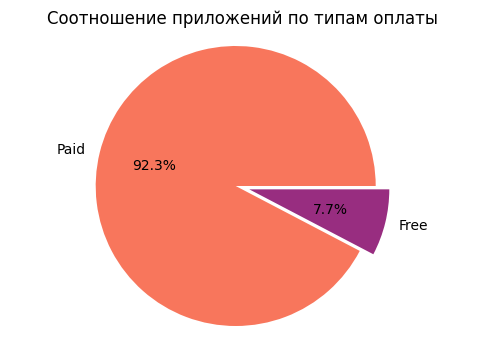

In [21]:
pie_builder(df,'type','app', 'Соотношение приложений по типам оплаты')

Бесплатных приложений существенно больше чем платных.

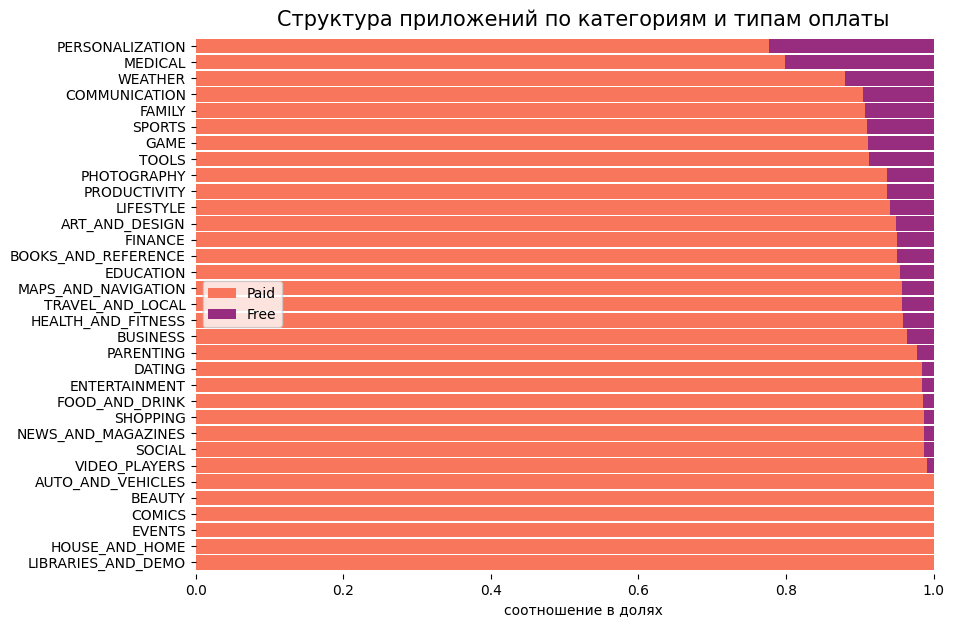

In [22]:
stacked_barplot_builder(df, 'category', 'type', 'app', "Структура приложений по категориям и типам оплаты", figsize=(10,7))

Структурно, есть полностью бесплатные приложения, в категории __personalization__ наибольшее соотношение платных

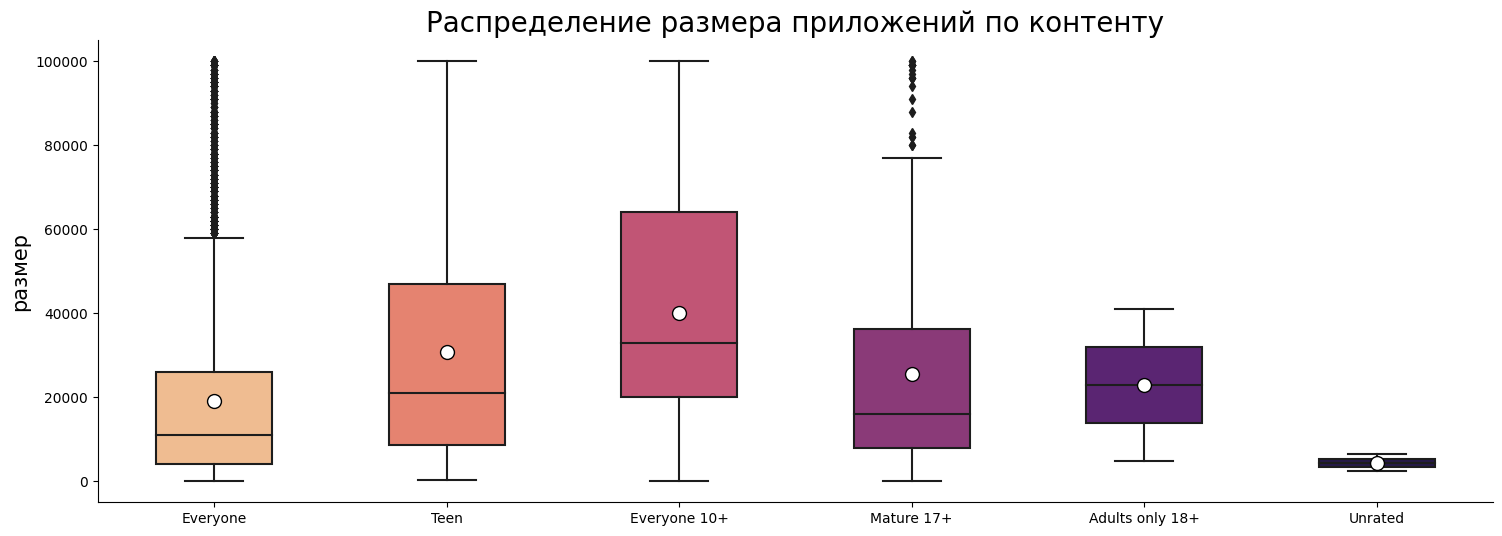

In [23]:
boxplot_builder(df, 'size','content_rating', 'размера приложений по контенту','размер', fliers=True, figsize=(18,6))

В разрезе возрастного контента по размеру приложения распределены преимущественно с тяжелыми хвостами, т.к. средние смещены относительно медиан. Примечательно, что приложения для взрослых распределены нормально, а у приложений __для всех__ очень много выбросов.

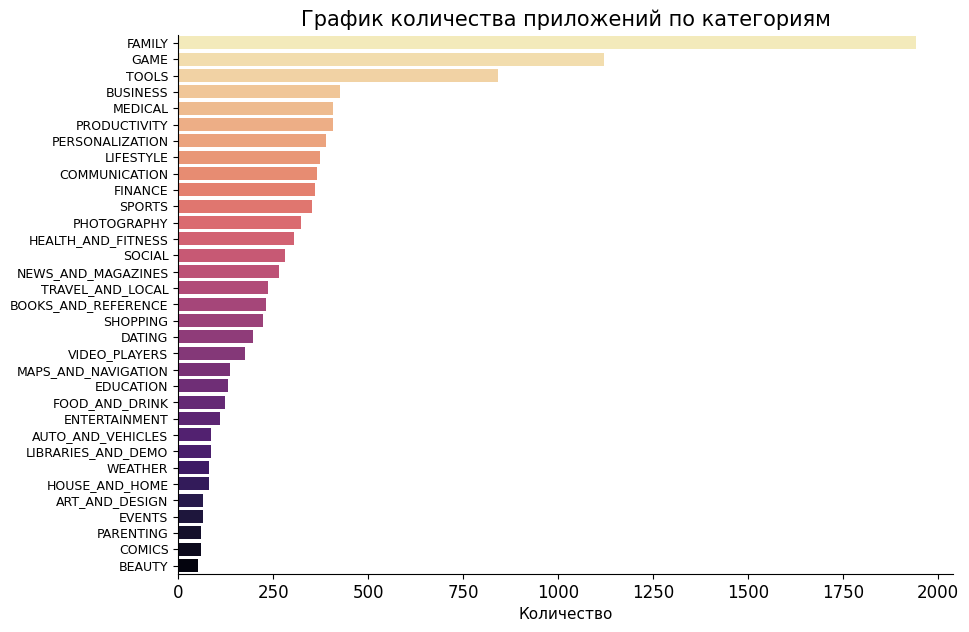

In [24]:
countplot_builder(df, 'category', 'количества приложений по категориям', '')

В абсолютном количественном выражении больше всего приложений категории __family__ меньше всего __beauty__

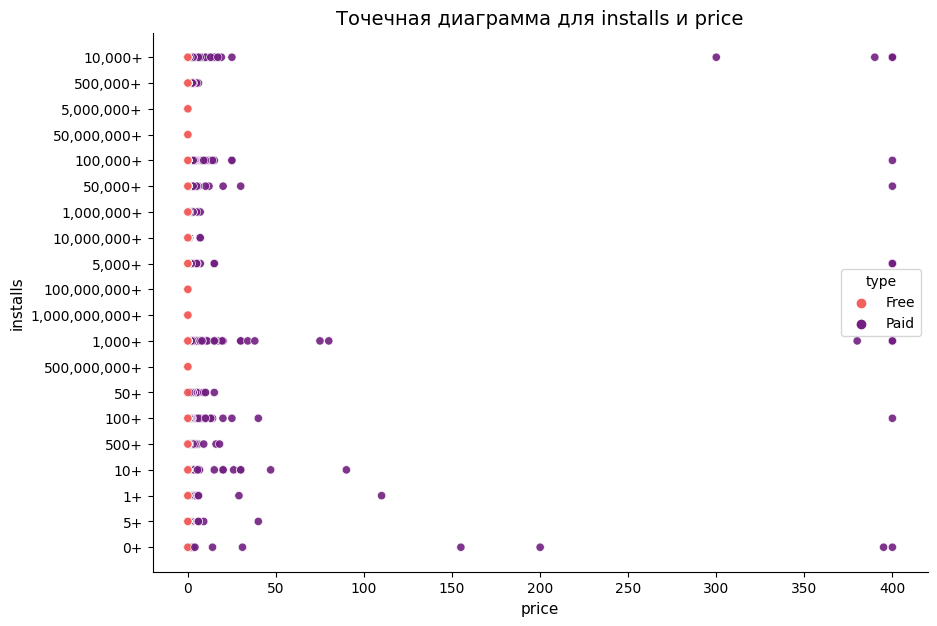

In [25]:
scatterplot_builder(df, 'installs', 'price', 'type')

Приложения установленные __5М и более__ раз полностью бесплатные. Скорее всего пользователи ставят фильтр на бесплатные и не факт что не удаляют после кратковременного использования, а к скачиванию платных подходят более осознано.

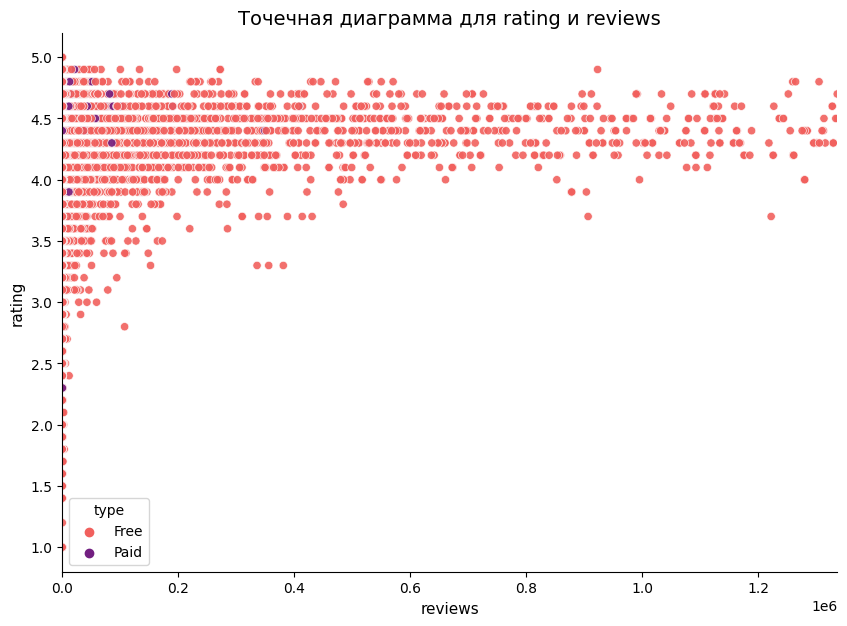

In [26]:
scatterplot_builder(df, 'rating', 'reviews', 'type',  outliers=True)

В плане обзоров находящихся между 5 и 95 персентилями самая адекватная оценка от 4.0 до 4.9. До 3 баллов и ближе к 5 ставят в основном приложениям с очень низкими просмотрами. Это говорит о субъективности оценок

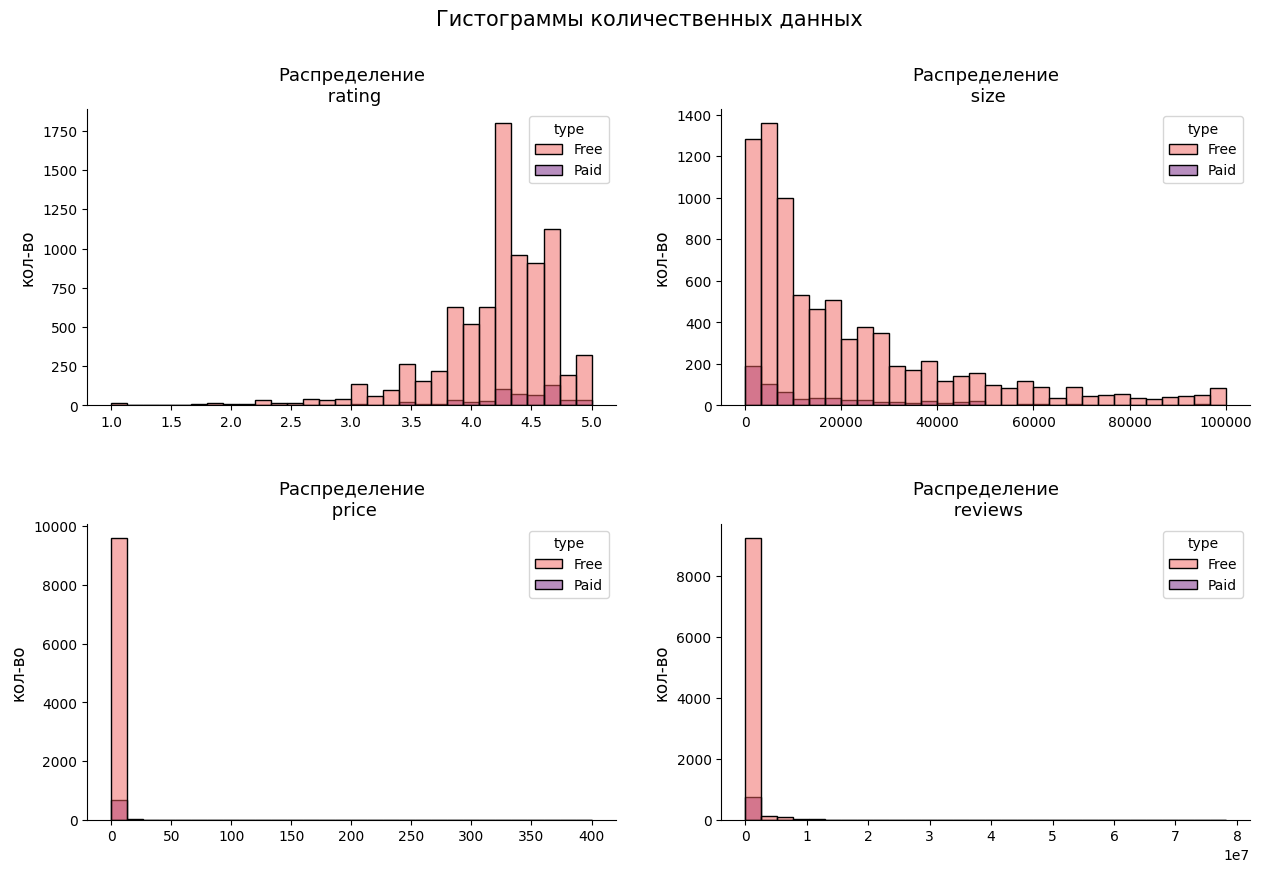

In [27]:
fig = plt.figure(figsize=(15,20))
cols = ['rating','size', 'price', 'reviews']
for i,col in enumerate(cols):
    fig.add_subplot(4, 2, i+1)
    sns.histplot(data=df, x=col, hue='type', palette=palette, bins=30)
    plt.title(f'Распределение\n {col}', size=13)
    plt.xlabel('', size=12)
    sns.despine()
    plt.ylabel('кол-во', size=12)
plt.suptitle('Гистограммы количественных данных', size=15, y=0.93)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()


На гистограммах количественные данные распределены разнообразно не нормально. 
- У рейтинга в распределении наблюдается тяжелая голова. Поставить плохую оценку гораздо проще чем похвалить, может с целью предостеречь окружающих, а может просто из вредности. 
- У размера естественно большинство программ легкие 
- В столбце __price__ и значения сосредоточены ближе к нулю. Это и понятно - большинство программ бесплатные или стоят пару долларов, но есть и большие выбросы по цене в __400 длларов__  
- В столбце __reviews__ данные также сосредоточены около минимума, но доходят до __80М__ просмотров. Скорее всего это старые программы бестселлеры со множеством обновлений, каждое из которых заслуживает внимание.

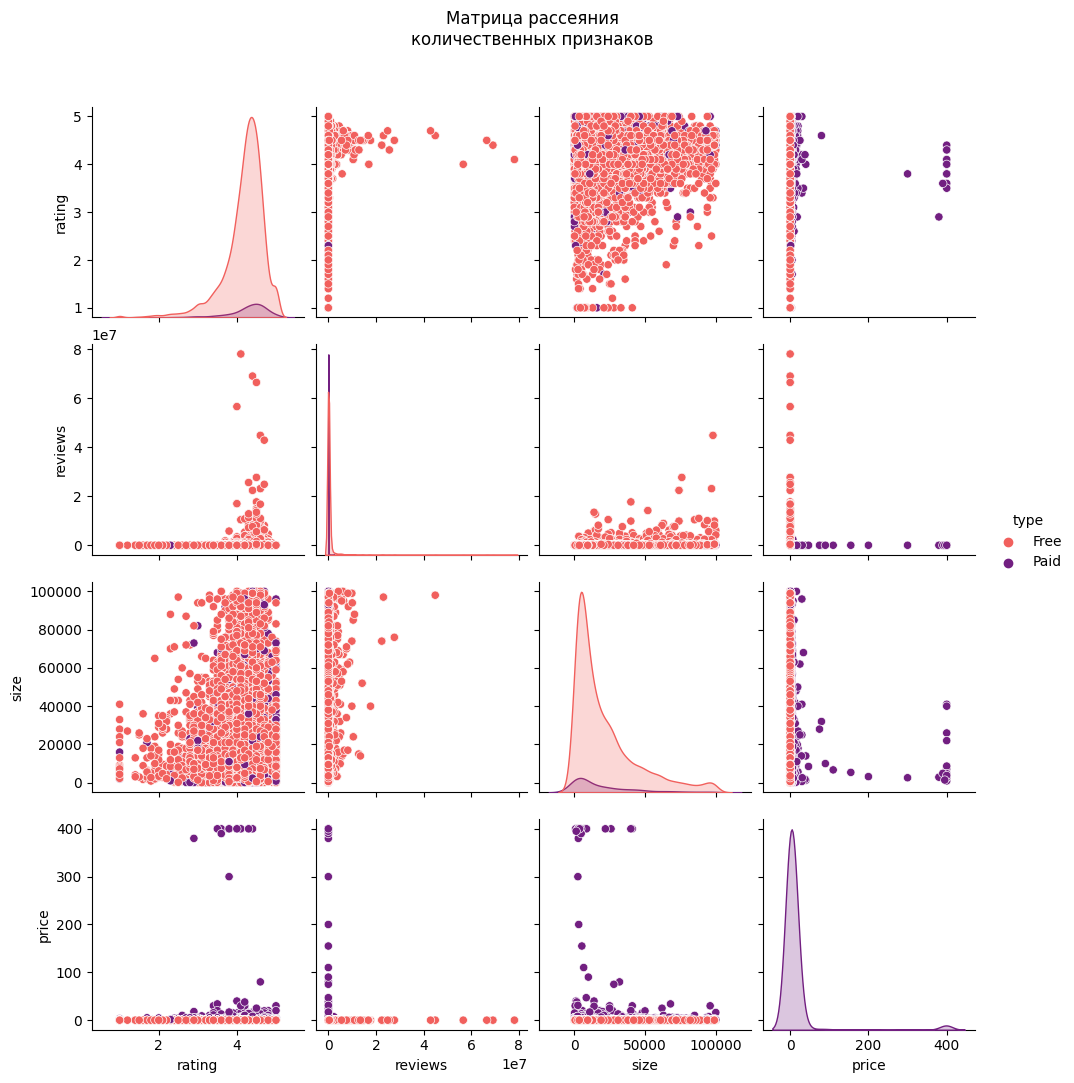

In [28]:
scatter_matrix_builder(df, 'type')

Матрица рассеяния объединяет предыдущие выводы. По диагонали это диаграммы плотности признаков (корреляция с самим собой бессмысленна, кроме автокорреляции временных рядов, но это другая история)

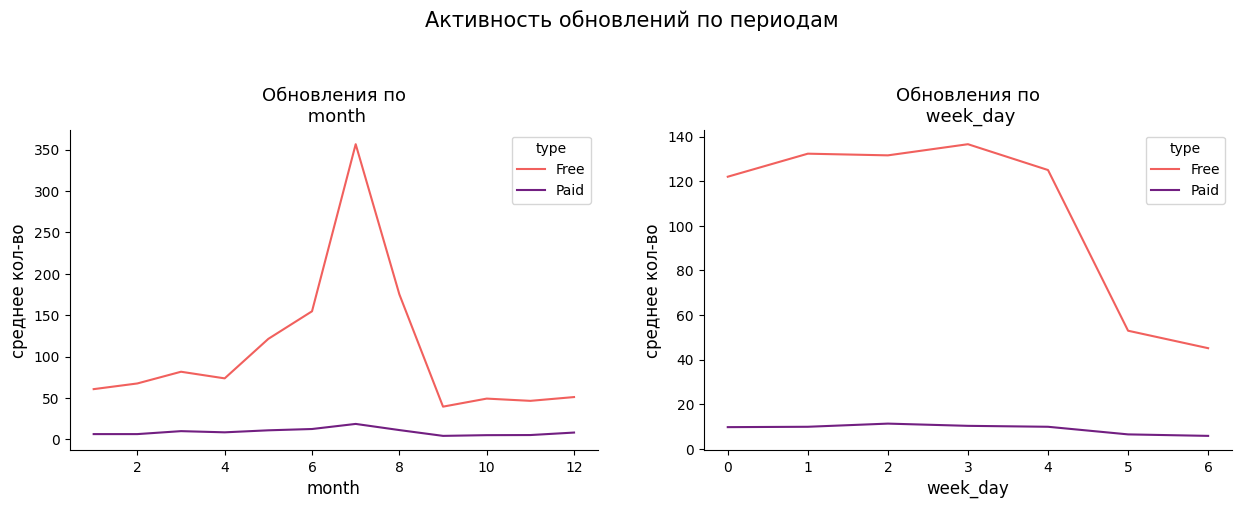

In [29]:
fig = plt.figure(figsize=(15,10))
time_columns = ['month', 'week_day']
updates_df = df.groupby(time_columns+['type']).agg({'app':'nunique'}).reset_index()
for i,col in enumerate(time_columns):
    fig.add_subplot(2, 2, i+1)
    sns.lineplot(data=updates_df, x=col, y='app', hue='type', palette=palette, errorbar=None, estimator='mean')
    plt.title(f'Обновления по\n {col}', size=13)
    plt.xlabel(col, size=12)
    sns.despine()
    plt.ylabel('среднее кол-во', size=12)
plt.suptitle('Активность обновлений по периодам', size=15, y=1.)
plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

Крайние обновления программ больше приходятся на летние месяцы и на первую половину недели

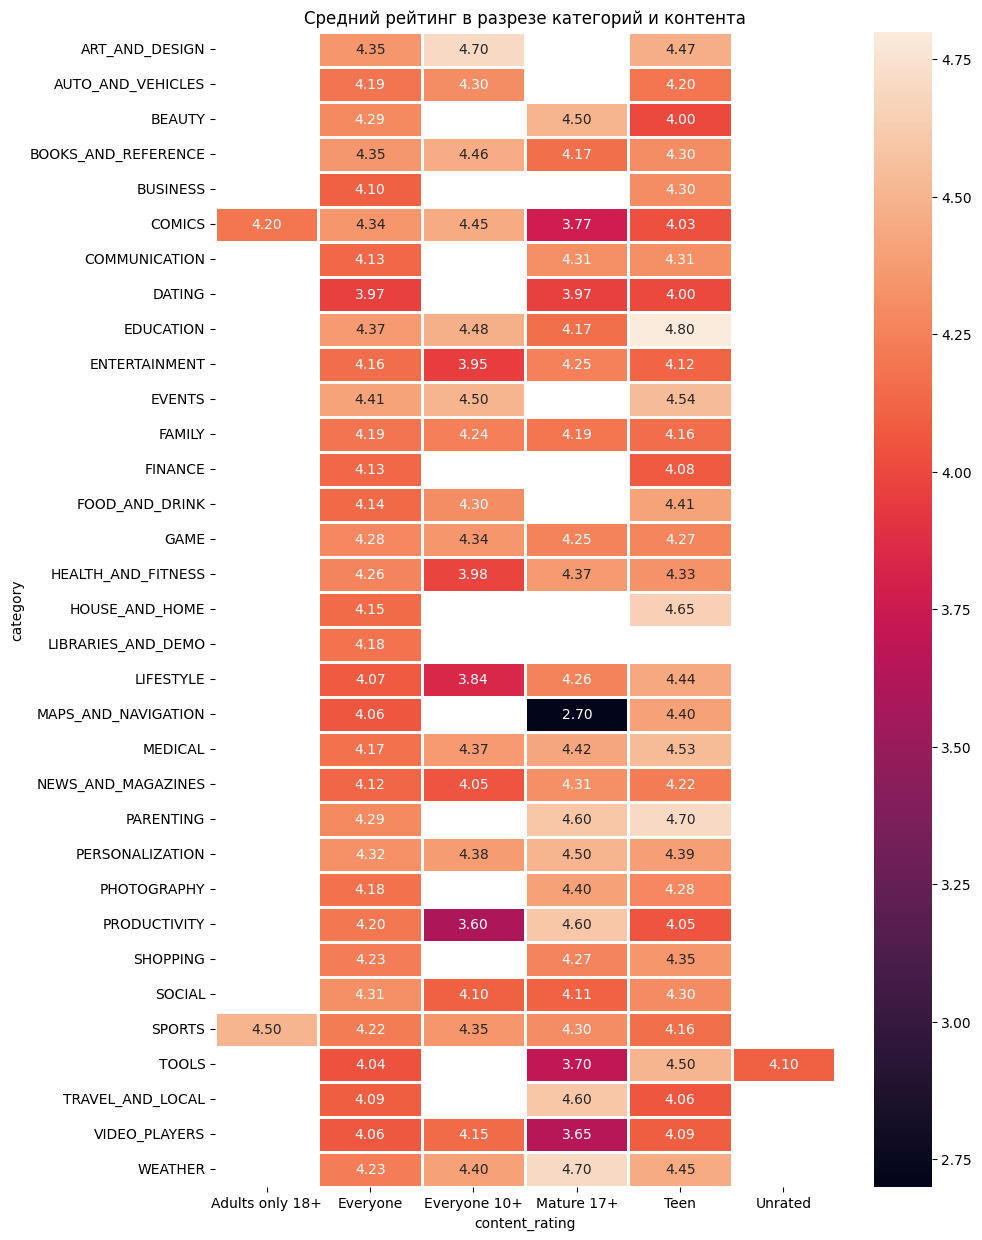

In [30]:
pivo = df.pivot_table(index='category', columns='content_rating', values='rating', aggfunc='mean', fill_value=None)
fig = plt.figure(figsize=(10,15))
sns.heatmap(pivo, annot=True, linecolor = 'white', linewidths=1, fmt=".2f")
plt.title('Средний рейтинг в разрезе категорий и контента')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

По категориям и возрастному рейтингу самые оцененные программы категории __для всех__, в основном свыше 4 баллов. Приложения для свиданий с самым низким рейтингом. Самый низкий рейтинг среди всех программ у __mature 17+__ - 2.7 балла